# Thresholding Classifiers using Imbalanced Datasets

Set up a classifier where we:
1. Test on a balanced training sample.
1. Use the trained classifier on a very imbalanced independent sample.

Then try to find various decision thresholds that optimize precision, F1 score, etc.

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, \
                            precision_recall_curve, precision_score, recall_score, \
                            f1_score, fbeta_score

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=14)

## Generate a balanced training set

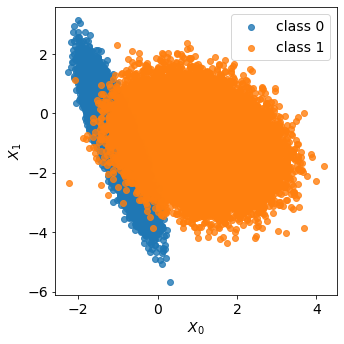

In [3]:
# It has 2 features and two classes, with 50% belonging to class 0 and 50% to class 1.
X, y = make_classification(n_samples=100000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.5], flip_y=0, random_state=4)

# Plot the features of the two classes.
fig, ax = plt.subplots(1,1, figsize=(5,5), tight_layout=True)

for yy in [0, 1]:
    select = y == yy
    ax.scatter(X[:,0][select], X[:,1][select], alpha=0.8, label='class {}'.format(yy))
ax.legend()
ax.set(xlabel='$X_0$',
       ylabel='$X_1$');

In [4]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

## Fit a Logistic regression model and compute ROC and PR curves

In [5]:
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

LogisticRegression()

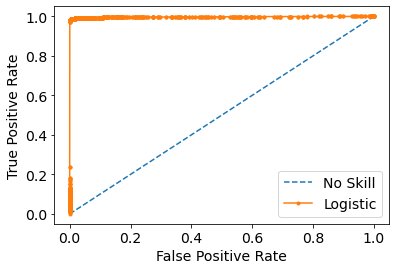

In [6]:
# predict probabilities
yhat = model.predict_proba(testX)

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# plot the roc curve for the model

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

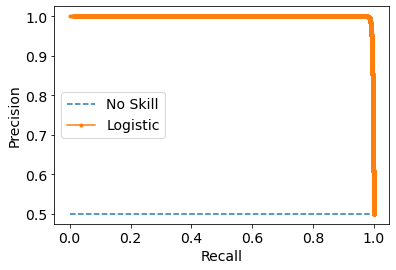

In [7]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(testy, yhat)

# plot the PR curve for the model
no_skill = len(testy[testy==1]) / len(testy)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

## Search thresholds for imbalanced classification

Note that the classifier's decision threshold is usually at ypred > 0.5 to assign label "1" to the data. This optimizes the threshold for the *balanced* dataset

In [8]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# keep probabilities for the positive outcome only
yhat = model.predict_proba(testX)
probs = yhat[:, 1]

thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(testy, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.448, F-Score=0.99042


## Make a very imbalanced data set

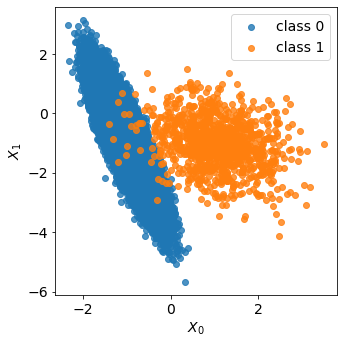

In [9]:
# Generate a very imbalanced dataset.
# It has 2 features and two classes, with 99% belonging to class 0 and 1% to class 1.
newX, newy = make_classification(n_samples=100000, n_features=2, n_redundant=0,
                                 n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

# Plot the features of the two classes.
fig, ax = plt.subplots(1,1, figsize=(5,5), tight_layout=True)

for yy in [0, 1]:
    select = newy == yy
    ax.scatter(newX[:,0][select], newX[:,1][select], alpha=0.8, label='class {}'.format(yy))
ax.legend()
ax.set(xlabel='$X_0$',
       ylabel='$X_1$');

## Check Precision, Recall, and F1 Score

### Use `argmax` of the predicted probability as the decision threshold

This effectively uses the label probabilty of 0.5 as the decision point.

In [10]:
yhat = model.predict_proba(newX)
ylabel = np.argmax(yhat, axis=1)
print('precision={:g}, recall={:g}, f1={:g}'.format(precision_score(newy, ylabel), recall_score(newy, ylabel), f1_score(newy, ylabel)))

precision=0.826453, recall=0.981, f1=0.897119


### Explicitly compute ypred > 0.5 as the decision threshold

Same thing as above; just check here that it produces the same answer, where we assume label 1 is the "signal" we want to keep.

In [11]:
ylabel = np.zeros_like(newy)
ylabel[yhat[:,1] > 0.5] = 1
print('precision={:g}, recall={:g}, f1={:g}'.format(precision_score(newy, ylabel), recall_score(newy, ylabel), f1_score(newy, ylabel)))

precision=0.826453, recall=0.981, f1=0.897119


### Scan through the label probability threshold to maximize precision

Let's say we want precision > 0.995, independent of its effect on recall. Scan through thresholds until we reach that precision.

As before, we assume that we want to correctly classify label 1.

In [12]:
prec, recall, f1 = 0., 0., 0.

for thresh in np.arange(0.5, 1, 0.001):
    ylabel = np.zeros_like(newy)
    ylabel[yhat[:,1] > thresh] = 1
    if precision_score(newy, ylabel) >= 0.995:
        prec = precision_score(newy, ylabel)
        recall = recall_score(newy, ylabel)
        f1 = f1_score(newy, ylabel)
        break
        
print('threshold = {:g}'.format(thresh))
print('precision={:g}, recall={:g}, f1={:g}'.format(prec, recall, f1))

threshold = 0.842
precision=0.995906, recall=0.973, f1=0.98432


### Scan through the label probability to maximize F1 score

In [13]:
prec, recall, f1, maxthresh = 0., 0., 0., 0.

for thresh in np.arange(0.5, 1, 0.001):
    ylabel = np.zeros_like(newy)
    ylabel[yhat[:,1] > thresh] = 1
    if f1_score(newy, ylabel) > f1:
        f1 = f1_score(newy, ylabel)
        prec = precision_score(newy, ylabel)
        recall = recall_score(newy, ylabel)
        maxthresh = thresh 
        
print('threshold = {:g}'.format(thresh))
print('precision={:g}, recall={:g}, f1={:g}'.format(prec, recall, f1))

threshold = 0.999
precision=0.997949, recall=0.973, f1=0.985316


### Scan through the label probability to maximize $F_{\beta}$, with $\beta<1$ weighted toward precision over recall

In [14]:
for beta in [0.1, 0.5, 1., 1.5, 2]:
    prec, recall, fb, maxthresh = 0., 0., 0., 0.

    for thresh in np.arange(0.5, 1, 0.001):
        ylabel = np.zeros_like(newy)
        ylabel[yhat[:,1] > thresh] = 1
        if fbeta_score(newy, ylabel, beta=beta) > fb:
            fb = fbeta_score(newy, ylabel, beta=beta)
            prec = precision_score(newy, ylabel)
            recall = recall_score(newy, ylabel)
            maxthresh = thresh 

    print('threshold = {:g}'.format(thresh))
    print('precision={:g}, recall={:g}, f_{{{:g}}}={:g}\n'.format(prec, recall, beta, fb))

threshold = 0.999
precision=1, recall=0.969, f_{0.1}=0.999683

threshold = 0.999
precision=1, recall=0.969, f_{0.5}=0.993642

threshold = 0.999
precision=0.997949, recall=0.973, f_{1}=0.985316

threshold = 0.999
precision=0.997949, recall=0.973, f_{1.5}=0.980543

threshold = 0.999
precision=0.990863, recall=0.976, f_{2}=0.978937

